# Back Reaction

## Initialization

In [1]:
%load_ext autoreload
import sys
sys.path.append("..")

In [2]:
%autoreload

import matplotlib
matplotlib.rc_file('matplotlibrc')
import matplotlib.pyplot as plt

%matplotlib inline

matplotlib.rcParams['figure.figsize'] = [10,10]


from astropy.io import fits

import numpy as np
import copy
import pickle

import darkhistory.physics as phys
import darkhistory.utilities as utils
import darkhistory.spec.spectools as spectools
import darkhistory.spec.transferfunction as tf
from darkhistory.spec.spectrum import Spectrum
from darkhistory.spec.spectra import Spectra
import darkhistory.history.tla as tla

from scipy.interpolate import interp1d

from tqdm import tqdm_notebook as tqdm

from darkhistory.electrons.ics.ics_spectrum import ics_spec
from darkhistory.electrons.ics.ics_engloss_spectrum import engloss_spec
from darkhistory.electrons.ics.ics_cooling import get_ics_cooling_tf

import darkhistory.low_energy.lowE_photons as lowE_photons
import darkhistory.low_energy.lowE_electrons as lowE_electrons

import scipy.interpolate

# np.set_printoptions(threshold=np.nan)

AHHHH YEAHHHH!


## Load Reference Results

These reference results start with a delta-function like injection at a redshift of $(1+z) = 31$ of 2 photons at the energy given by the file name. The high energy photons are stored in `file_photonspectrum`, low energy photons in `file_lowengphot` and low energy electrons in `file_lowengelec`. The photon energy abscissa is `file_eng` (both high and low) while the electron energy abscissa is `file_eleceng`. 

In [40]:
eng_ind = 95
eng_exp = {95: 3.884, 195: 6.077, 295: 8.271, 395: 10.46, 495: 12.66}[eng_ind]
user = "hongwan"

# Check that this matches with the input 

# file_name = {99: "/Users/hongwan/Dropbox (MIT)/Photon Deposition/tf_z_3.100E+01_nstep_2049_logE_5.328E+00_xe_1.000E-04.fits",
#             199: "/Users/hongwan/Dropbox (MIT)/Photon Deposition/tf_z_3.100E+01_nstep_2049_logE_7.183E+00_xe_1.000E-04.fits",
#             298: "/Users/hongwan/Dropbox (MIT)/Photon Deposition/tf_z_3.100E+01_nstep_2049_logE_9.020E+00_xe_1.000E-04.fits",
#             299: "/Users/hongwan/Dropbox (MIT)/Photon Deposition/tf_z_3.100E+01_nstep_2049_logE_9.038E+00_xe_1.000E-04.fits", 
#             399: "/Users/hongwan/Dropbox (MIT)/Photon Deposition/tf_z_3.100E+01_nstep_2049_logE_1.089E+01_xe_1.000E-04.fits",
#             499: "/Users/hongwan/Dropbox (MIT)/Photon Deposition/tf_z_3.100E+01_nstep_2049_logE_1.275E+01_xe_1.000E-04.fits",
#             2993: "/Users/hongwan/Dropbox (MIT)/Photon Deposition/tf_z_3.100E+01_nstep_18_logE_9.038E+00_xe_1.000E-04.fits"}

# file_name = {95: "/Users/"+user+"/Dropbox (MIT)/Photon Deposition/tf_z_3.100E+01_nstep_2049_logE_3.884E+00_xe_2.746E-04.fits",
#             195: "/Users/"+user+"/Dropbox (MIT)/Photon Deposition/tf_z_3.100E+01_nstep_2049_logE_6.077E+00_xe_2.746E-04.fits",
#             295: "/Users/"+user+"/Dropbox (MIT)/Photon Deposition/tf_z_3.100E+01_nstep_2049_logE_8.271E+00_xe_2.746E-04.fits",
#             395: "/Users/"+user+"/Dropbox (MIT)/Photon Deposition/tf_z_3.100E+01_nstep_2049_logE_1.046E+01_xe_2.746E-04.fits", 
#             495: "/Users/"+user+"/Dropbox (MIT)/Photon Deposition/tf_z_3.100E+01_nstep_2049_logE_1.266E+01_xe_2.746E-04.fits"}

file_name = {95: "/Users/"+user+"/Dropbox (MIT)/Photon Deposition/fixed_binning_data/tf_z_3.100E+01_nstep_2049_logE_3.884E+00_xe_2.746E-04.fits",
            195: "/Users/"+user+"/Dropbox (MIT)/Photon Deposition/fixed_binning_data/tf_z_3.100E+01_nstep_2049_logE_6.077E+00_xe_2.746E-04.fits",
            295: "/Users/"+user+"/Dropbox (MIT)/Photon Deposition/fixed_binning_data/tf_z_3.100E+01_nstep_2049_logE_8.271E+00_xe_2.746E-04.fits",
            395: "/Users/"+user+"/Dropbox (MIT)/Photon Deposition/fixed_binning_data/tf_z_3.100E+01_nstep_2049_logE_1.046E+01_xe_2.746E-04.fits", 
            495: "/Users/"+user+"/Dropbox (MIT)/Photon Deposition/fixed_binning_data/tf_z_3.100E+01_nstep_2049_logE_1.266E+01_xe_2.746E-04.fits"}


file = fits.open(file_name[eng_ind])

file_eng     = file[1].data['energy'][0,:]
file_eleceng = file[1].data['eleceng'][0,:]
file_rs      = file[1].data['redshift'][0,:]

file_photonspectrum = file[1].data['photonspectrum'][0,:,:]
file_lowengphot     = file[1].data['lowengphot'][0,:,:]
file_lowengelec     = file[1].data['lowengelec'][0,:,:]
file_cmbloss        = file[1].data['cmblosstable'][0,:]

file_photeng_bin_bound = spectools.get_bin_bound(file_eng)
file_eleceng_bin_bound = spectools.get_bin_bound(file_eleceng)

file_photeng_bin_width = np.diff(file_photeng_bin_bound)
file_eleceng_bin_width = np.diff(file_eleceng_bin_bound)

Turn the data into `Spectra` objects. 

In [41]:
# Multiply by bin width, and then save as spec_type = 'N'. Consistent with Tracy's definitions.
file_highengphot_spectra = Spectra([Spectrum(file_eng, photspec*file_photeng_bin_width, spec_type='N', rs=rs) 
    for photspec,rs in zip(file_photonspectrum, file_rs)])

file_lowengphot_spectra = Spectra([Spectrum(file_eng, photspec*file_photeng_bin_width, spec_type='N', rs=rs) 
    for photspec,rs in zip(file_lowengphot, file_rs)])

file_lowengelec_spectra = Spectra([Spectrum(file_eleceng, elecspec*file_eleceng_bin_width, spec_type='N', rs=rs) 
    for elecspec,rs in zip(file_lowengelec, file_rs)])

In [42]:
print(file_highengphot_spectra[1].toteng())
print(file_lowengphot_spectra[1].toteng())
print(file_lowengelec_spectra[1].toteng())
print(file_cmbloss[1])

print(file_highengphot_spectra[1].toteng() - file_highengphot_spectra[2].toteng() 
    + file_lowengphot_spectra[2].toteng() + file_lowengelec_spectra[2].toteng()
      - file_cmbloss[2] - file_highengphot_spectra[1].toteng()*0.001
     )

15296.332923676951
0.39027425264609295
0.5605320323133633
8.068131674136275e-14
1.1480910478441384


## Photon Cooling

Now we cool the photons that result from the high energy photon injection. Photons below 3.1 keV are considered low energy photons. For high energy photons, greater than 3.1 keV, we have transfer functions into high energy photons, low energy photons and low energy electrons. Let's load them first. These are saved as arrays of `TransFuncList` objects, for a list of 10 different levels of $x_e$.

In [43]:
user = 'hongwan'

highengphot_tflist_arr_raw = pickle.load(open("/Users/"+user+"/Dropbox (MIT)/Photon Deposition/tfunclist_photspec_60eV_list_new.raw", "rb"))
lowengphot_tflist_arr_raw  = pickle.load(open("/Users/"+user+"/Dropbox (MIT)/Photon Deposition/tfunclist_lowengphotspec_60eV_list_new.raw", "rb"))
lowengelec_tflist_arr_raw  = pickle.load(open("/Users/"+user+"/Dropbox (MIT)/Photon Deposition/tfunclist_lowengelecspec_60eV_list_new.raw", "rb"))
CMB_engloss_raw = pickle.load(open("/Users/"+user+"/Dropbox (MIT)/Photon Deposition/CMB_engloss_60eV_list_new.raw", "rb"))

For checks, we may want to use just one particular set of transfer functions. If so, we should run this cell.

In [44]:
tflist_xe_ind = 0
# Note that for now, highengphot_tflist_arr_raw only has one entry, and in actual fact has an ionization
# corresponding to 0.5 + 0.5*np.tanh(4.1). But we set this to 0 here instead of 1 to access the single element
# in the array.

print(0.5 + 0.5*np.tanh([-5., -4.1, -3.2, -2.3, -1.4, -0.5, 0.4, 1.3, 2.2, 3.1, 4]))

highengphot_tflist_arr = [highengphot_tflist_arr_raw[tflist_xe_ind]]
lowengphot_tflist_arr  = [lowengphot_tflist_arr_raw[tflist_xe_ind]]
lowengelec_tflist_arr  = [lowengelec_tflist_arr_raw[tflist_xe_ind]]
CMB_engloss_arr = CMB_engloss_raw[0]

[4.53978687e-05 2.74578156e-04 1.65880108e-03 9.95180187e-03
 5.73241759e-02 2.68941421e-01 6.89974481e-01 9.30861580e-01
 9.87871565e-01 9.97974680e-01 9.99664650e-01]


## Inputs

Next, we define the input spectrum. Currently, `eleceng` and `photeng` must be defined as follows for accuracy, although `n` can be adjusted for speed. Here, we define a delta-function like injection at `mwimp_arr[eng_ind]`, which will correspond exactly with the reference file chosen. Note that `spectools.rebin_N_arr` produces a `Spectrum` object of type `'dNdE'` by default, so `Spectrum.switch_spec_type()` is required, since all of the transfer functions evolve `Spectrum` objects of type `'N'`. 

In [45]:
# mwimp_arr = np.array(highengphot_tflist_arr[0].in_eng)

# mwimp_arr = {99: 10**5.328, 199: 10**7.183, 298: 10**9.020, 299: 10**9.038, 
#             399: 10**10.89, 499: 10**12.72}

mwimp = file[1].data['mwimp'][0]
eleceng = lowengelec_tflist_arr[0].eng
photeng = highengphot_tflist_arr[0].eng

# step = np.log(photeng[1]) - np.log(photeng[0])
# test = np.exp(np.arange(np.log(photeng[0]), np.log(9.9e-5), -step))
# photeng = np.append(np.flipud(test[1:]), photeng)

# eleceng = eleceng[1::n]
# photeng = photeng[1::n]

# phot_spec_init = spectools.rebin_N_arr(np.array([2]), 
#                                       np.array([mwimp_arr[eng_ind]]),
#                                       photeng)

# fac = mwimp/file_eng[-1]

# phot_spec_init = spectools.rebin_N_arr(np.array([2*fac]), 
#                                       np.array([file_eng[-1]]),
#                                        photeng
#                                       )

eng_bin_to_find = file_eng[file_eng < mwimp][-1]

fac = mwimp/eng_bin_to_find

phot_spec_init = spectools.rebin_N_arr(np.array([2*fac]), 
                                      np.array([eng_bin_to_find]), 
                                      photeng)

phot_spec_init.switch_spec_type()

In [46]:
utils.compare_arr([eleceng,file_eleceng])

[[1.02978258e+00 1.02978258e+00]
 [1.09203515e+00 1.09203515e+00]
 [1.15805103e+00 1.15805103e+00]
 [1.22805771e+00 1.22805771e+00]
 [1.30229645e+00 1.30229645e+00]
 [1.38102307e+00 1.38102307e+00]
 [1.46450889e+00 1.46450889e+00]
 [1.55304161e+00 1.55304161e+00]
 [1.64692632e+00 1.64692632e+00]
 [1.74648657e+00 1.74648657e+00]
 [1.85206545e+00 1.85206545e+00]
 [1.96402679e+00 1.96402679e+00]
 [2.08275644e+00 2.08275644e+00]
 [2.20866356e+00 2.20866356e+00]
 [2.34218203e+00 2.34218203e+00]
 [2.48377198e+00 2.48377198e+00]
 [2.63392135e+00 2.63392135e+00]
 [2.79314757e+00 2.79314757e+00]
 [2.96199936e+00 2.96199936e+00]
 [3.14105861e+00 3.14105861e+00]
 [3.33094237e+00 3.33094237e+00]
 [3.53230501e+00 3.53230501e+00]
 [3.74584046e+00 3.74584046e+00]
 [3.97228459e+00 3.97228459e+00]
 [4.21241775e+00 4.21241775e+00]
 [4.46706748e+00 4.46706748e+00]
 [4.73711134e+00 4.73711134e+00]
 [5.02347992e+00 5.02347992e+00]
 [5.32716011e+00 5.32716011e+00]
 [5.64919842e+00 5.64919842e+00]
 [5.990704

0

In [10]:
print(10**8.271)
print(mwimp)
print(file_eng[-1])
print(fac)
print(file_highengphot_spectra[300].N[1:10])


186637969.08346733
7654.023463987041
5355424908402.668
1.0720913107886019
[3.88087767e-38 4.19199767e-38 4.52805936e-38 4.89106225e-38
 5.28316615e-38 5.70670402e-38 6.16419582e-38 6.65836358e-38
 7.19214690e-38]


To evolve the spectrum and allow for easy processing later, the high energy photon transfer function must be square. We make the abscissa for the transfer function `photeng` by `photeng` (injected energy by output energy), and simply pad the additional rows needed with zeros. For convenience, we also use `photeng` by `photeng` for the low energy photon transfer function, and `photeng` by `eleceng` for the low energy electron transfer function. The definitions for high and low energies are listed below. 

In [11]:
#Split photeng into high and low energy. 
photeng_high = photeng[photeng > 60]
photeng_low  = photeng[photeng <= 60]

# Split eleceng into high and low energy. 
eleceng_high = eleceng[eleceng > 3000]
eleceng_low  = eleceng[eleceng <= 3000]


for highengphot_tflist in highengphot_tflist_arr:
    
#     highengphot_tflist.at_val('in_eng', photeng_high, bounds_error=False, fill_value=0)

    for tf in highengphot_tflist:
        # tf.rebin(photeng_high)
#         tf.rebin(photeng)
        
        # Pad with zeros so that it becomes photeng x photeng. 
        tf._grid_vals = np.pad(tf.grid_vals, ((photeng_low.size, 0), (0, 0)), 'constant')
        tf._N_underflow = np.pad(tf._N_underflow, (photeng_low.size, 0), 'constant')
        tf._eng_underflow = np.pad(tf._eng_underflow, (photeng_low.size, 0), 'constant')
        tf._in_eng = photeng
        tf._eng = photeng
        tf._rs = tf.rs[0]*np.ones_like(photeng)
    
    highengphot_tflist.eng = photeng
    highengphot_tflist.in_eng = photeng
    
# lowengphot_tflist.in_eng set to photeng_high
for lowengphot_tflist in lowengphot_tflist_arr:
    
#     lowengphot_tflist.at_val('in_eng', photeng_high, bounds_error=False, fill_value=0)
    
    for tf in lowengphot_tflist:
#         tf.rebin(photeng)
        # Pad with zeros so that it becomes photeng x photeng. 
        tf._grid_vals = np.pad(tf.grid_vals, ((photeng_low.size,0), (0,0)), 'constant')
        # Photons in the low energy bins should be immediately deposited.
        tf._grid_vals[0:photeng_low.size, 0:photeng_low.size] = np.identity(photeng_low.size)
        tf._N_underflow = np.pad(tf._N_underflow, (photeng_low.size, 0), 'constant')
        tf._eng_underflow = np.pad(tf._eng_underflow, (photeng_low.size, 0), 'constant')
        tf._in_eng = photeng
        tf._eng = photeng
        tf._rs = tf.rs[0]*np.ones_like(photeng)
    
    lowengphot_tflist.eng = photeng
    lowengphot_tflist.in_eng = photeng
    
# lowengelec_tflist.in_eng set to photeng_high 
for lowengelec_tflist in lowengelec_tflist_arr:
    
#     lowengelec_tflist.at_val('in_eng', photeng_high, bounds_error=False, fill_value=0)
    
    for tf in lowengelec_tflist:
#         tf.rebin(eleceng)
        # Pad with zeros so that it becomes photeng x eleceng. 
        tf._grid_vals = np.pad(tf.grid_vals, ((photeng_low.size,0), (0,0)), 'constant')
        tf._N_underflow = np.pad(tf._N_underflow, (photeng_low.size, 0), 'constant')
        tf._eng_underflow = np.pad(tf._eng_underflow, (photeng_low.size, 0), 'constant')
        tf._in_eng = photeng
        tf._eng = eleceng
        tf._rs = tf.rs[0]*np.ones_like(photeng)

    lowengelec_tflist.eng = eleceng
    lowengelec_tflist.in_eng = photeng
    
CMB_engloss_arr = np.pad(CMB_engloss_arr, ((0,0),(photeng_low.size, 0)), 'constant')


In [12]:
CMB_engloss_arr.shape

(51, 500)

## Coarsening

We need to decide on the redshift step to use. The default redshift step in the transfer functions is $d \log (1+z) = 0.002$, with the transfer function with this step size evaluated at (currently) 50 redshifts, from $z = 30$ to $z = 4$. If we stick with this step size, then we must interpolate the transfer function at 2049 points between $z = 30$ and $z = 4$, so that every multiplication by the transfer function advances the spectrum by a step of $d \log (1+z) = 0.002$. 

However, we can coarsen the high energy photon transfer function by some factor $f$ by multiplying the transfer function matrix by itself multiple times, producing transfer functions for a redshift step of $d \log (1+z) = f \times 0.002$. The assumption here is that the transfer function does not change significantly over this bigger redshift step, which appears to be a good approximation in all of the cases checked so far. We will then have to interpolate the transfer function at $2049/f$ steps, and perform $2049/f$ matrix multiplications to evolve the spectrum from $z=30$ to $z=4$. 

This is performed using the function `TransferFuncList.coarsen()`. There are two types of coarsening: one is for a propagation matrix, where we simply multiply the transfer function by itself multiple times (here given by `coarsen_factor`). The other is for a deposition matrix. The deposition matrix is taken to be constant over the number of steps given by `coarsen_factor`, and is applied to the high energy photon spectrum that is produced by each multiplication of the transfer function to get to the next redshift. After coarsening, if the propagation transfer function is $P$, and the deposition transfer function is $D$, coarsening returns $B (1 + P + \cdots + P^{n-1})$. 

After coarsening, the resulting transfer functions are then interpolated at the redshifts given in `rs_list`. 

In [13]:
# The redshift step to use will be coarsen_factor * 0.002
coarsen_factor = 1
# Generate the redshifts at which we want to get an interpolated value for the transfer function. 
tf_rs_arr = highengphot_tflist_arr[0].rs
rs_list = np.exp(np.arange(np.log(tf_rs_arr[0]), 
                           np.log(tf_rs_arr[-1])-highengphot_tflist_arr[0].dlnz*coarsen_factor, 
                           -highengphot_tflist_arr[0].dlnz*coarsen_factor)
                )

rs_list[-1] = max(4., rs_list[-1])

if coarsen_factor > 1:
    for (
        lowengphot_tflist, lowengelec_tflist, highengphot_tflist
    )in tqdm(zip(
        lowengphot_tflist_arr, lowengelec_tflist_arr, highengphot_tflist_arr
    )):
        lowengphot_tflist.coarsen(coarsen_factor, delete_tfs=False, coarsen_type='dep', prop_transfunclist=highengphot_tflist)
        lowengelec_tflist.coarsen(coarsen_factor, delete_tfs=False, coarsen_type='dep', prop_transfunclist=highengphot_tflist)
        highengphot_tflist.coarsen(coarsen_factor, delete_tfs=False)
    
lowengphot_tflist.at_val('rs',rs_list)
lowengelec_tflist.at_val('rs',rs_list)
highengphot_tflist.at_val('rs',rs_list)

phot_spec_init.rs = rs_list[0]





In [14]:
print(tf_rs_arr.shape)
print(CMB_engloss_arr.shape)
CMB_engloss_interp = interp1d(tf_rs_arr, CMB_engloss_arr, axis=0)

CMB_engloss = CMB_engloss_interp(rs_list)
print(CMB_engloss.shape)


(51,)
(51, 500)
(1025, 500)


## Transfer Function Checks

Let's do the check for the transfer functions first. We'll just use the first `tflist` in each list as a check.

Now we evolve the initial photon spectrum across all of the redshifts specified in `rs_list`, using the coarsened transfer functions. This is performed by calling the function `spectools.evolve()`, which takes as arguments the initial spectrum, the list of propagation transfer functions, as well as a list of deposition transfer functions. We want to use `evolve_type='prop'` for the high energy photons (just propagation) and `evolve_type='dep'` for low energy electrons and photons, in which case we must specify both propagation and deposition transfer matrices. `save_steps` determines whether the output is a single `Spectrum` at the end of the whole propagation, or a `Spectra` object, which records the spectrum at each intermediate step.

In [15]:

highengphot_spectra = spectools.evolve(
    phot_spec_init, highengphot_tflist_arr[0], evolve_type='prop', save_steps=True
)
lowengphot_spectra  = spectools.evolve(
    phot_spec_init, lowengphot_tflist_arr[0], evolve_type='dep',
    prop_tflist=highengphot_tflist_arr[0], save_steps=True
)
lowengelec_spectra = spectools.evolve(
    phot_spec_init, lowengelec_tflist_arr[0],
    evolve_type='dep', prop_tflist=highengphot_tflist_arr[0], save_steps=True
)

We can now obtain the energy loss from upscattered CMB photons using `CMB_engloss`. 

In [16]:
print(CMB_engloss.shape)
cmbloss = highengphot_spectra.integrate_each_spec(CMB_engloss)
print(cmbloss.size)



(1025, 500)
1025


Here, we process the data from our reference files in order to make the comparison with our result. First, we need to rebin the reference file spectra into the same energy abscissa as our output from above. 

In [17]:
file_highengphot_spectra.rebin(highengphot_spectra.eng)
# file_highengphot_spectra.switch_spec_type()
file_lowengphot_spectra.rebin(lowengphot_spectra.eng)
# file_lowengphot_spectra.switch_spec_type()
file_lowengelec_spectra.rebin(lowengelec_spectra.eng)
# file_lowengelec_spectra.switch_spec_type()

Because we have coarsened our deposition transfer function, the output in `lowengphot_spectra` and `lowengelec_spectra` is actually equivalent to the total deposition from a number of steps given by `coarsen_factor` in the original file. We have to add up all of the deposited low energy electrons and photons in the reference file in order to make the correct comparison.

In [18]:
combined_file_lowengphot_spectra = Spectra([], spec_type='N')
combined_file_lowengelec_spectra = Spectra([], spec_type='N')
combined_file_cmbloss = np.zeros(np.floor_divide(2049,2*coarsen_factor))

# for i in np.arange(np.floor_divide(2049,2*coarsen_factor)-1):
#     mask = np.zeros(2049)
#     mask[2*i*coarsen_factor+1:(2*i+2)*coarsen_factor+1] = 1
#     out_spec_phot = file_lowengphot_spectra.sum_specs(mask)
#     out_spec_elec = file_lowengelec_spectra.sum_specs(mask)
#     combined_file_cmbloss[i+1] = np.sum(file_cmbloss[2*i*coarsen_factor+1:(2*i+2)*coarsen_factor+1])
#     out_spec_phot.rs = file_lowengphot_spectra[(2*i+2)*coarsen_factor].rs
#     out_spec_elec.rs = file_lowengelec_spectra[(2*i+2)*coarsen_factor].rs
#     combined_file_lowengphot_spectra.append(out_spec_phot)
#     combined_file_lowengelec_spectra.append(out_spec_elec)

i = 1
while i < 2049:
    mask = np.zeros(2049)
    mask[i:i+2] = 1
    out_spec_phot = file_lowengphot_spectra.sum_specs(mask)
    out_spec_elec = file_lowengelec_spectra.sum_specs(mask)
    combined_file_cmbloss[(i-1)//2] = np.sum(file_cmbloss[i:i+2])
    out_spec_phot.rs = file_lowengphot_spectra[i+1].rs
    out_spec_elec.rs = file_lowengelec_spectra[i+1].rs
    combined_file_lowengphot_spectra.append(out_spec_phot)
    combined_file_lowengelec_spectra.append(out_spec_elec)
    i += 2

[0.0001, 2000000.0, 1e-38, 1]

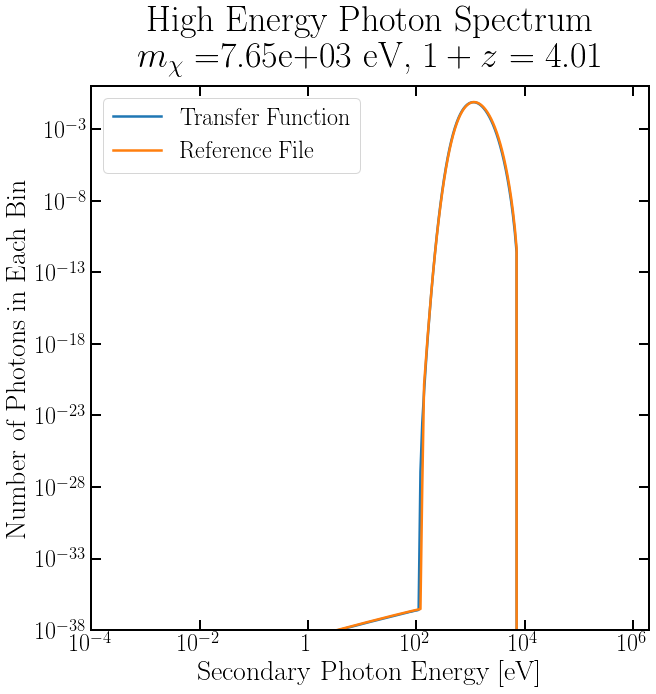

In [33]:
plt.figure()

rs_plot = 4.01

ax = plt.gca()

tf_plot, = highengphot_spectra.plot(ax, fac=1, ind=rs_plot, indtype='rs')
# tf_plot, = highengphot_spectra.plot(ax, ind=20)
file_plot, = file_highengphot_spectra.plot(ax, ind=rs_plot, indtype='rs')
# file_plot, = file_highengphot_spectra.plot(ax, ind=20)

plt.title('High Energy Photon Spectrum\n' + r'$m_\chi$ ='
          +'{:.2e}'.format(mwimp)
          +r' eV, $1+z$ = '+'{0:.2f}'.format(rs_plot)
         )

ax.legend((tf_plot, file_plot), ('Transfer Function', 'Reference File'))
ax.set_xscale('log')
ax.set_yscale('log')

plt.xlabel('Secondary Photon Energy [eV]')
plt.ylabel('Number of Photons in Each Bin')
plt.axis([1e-4, 2e6, 1e-38, 1])

In [20]:
i = 10
print(highengphot_spectra[i].totN())
print(highengphot_spectra[i].toteng())
print(file_highengphot_spectra[2*i].totN())
print(file_highengphot_spectra[2*i].toteng())

2.1435719961548463
15003.532774940564
2.1428460808526957
15004.463220836522


30.325447286587586


[0.0001, 10000.0, 1e-44, 30]

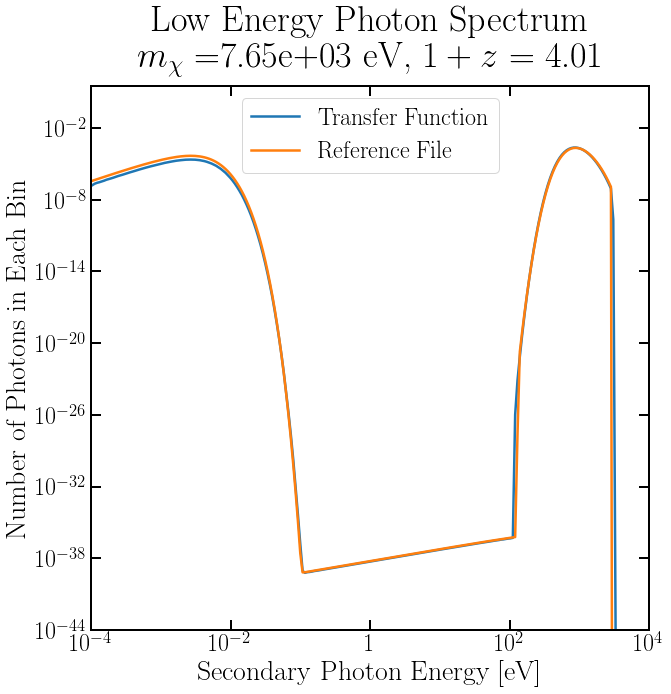

In [34]:
plt.figure()

rs_plot = 4.01

ax = plt.gca()
print(lowengphot_spectra.rs[11])
tf_plot, = lowengphot_spectra.plot(ax, ind=rs_plot, fac=1, indtype='rs')
file_plot, = combined_file_lowengphot_spectra.plot(ax, ind=rs_plot, indtype='rs')
# tf_plot, = lowengphot_spectra.plot(ax, ind=20)
# file_plot, = combined_file_lowengphot_spectra.plot(ax, ind=20)


ax.set_xscale('log')
ax.set_yscale('log')

plt.title('Low Energy Photon Spectrum\n' + r'$m_\chi$ ='
          +'{:.2e}'.format(mwimp)
          +r' eV, $1+z$ = '+'{0:.2f}'.format(rs_plot)
         )

ax.legend((tf_plot, file_plot), ('Transfer Function', 'Reference File'))


plt.xlabel('Secondary Photon Energy [eV]')
plt.ylabel('Number of Photons in Each Bin')
plt.axis([1e-4, 1e4, 1e-44, 30])

In [22]:
i = 1023
print(lowengphot_spectra.rs.shape)
print(combined_file_lowengphot_spectra.rs.shape)
print(lowengphot_spectra[i].totN())
print(lowengphot_spectra[i].toteng())
print(combined_file_lowengphot_spectra[i].totN())
print(combined_file_lowengphot_spectra[i].toteng())

(1024,)
(1024,)
0.002579399872610806
1.91187059097784
0.002987543787182813
1.847006336749833


[1, 4000.0, 1e-15, 0.001]

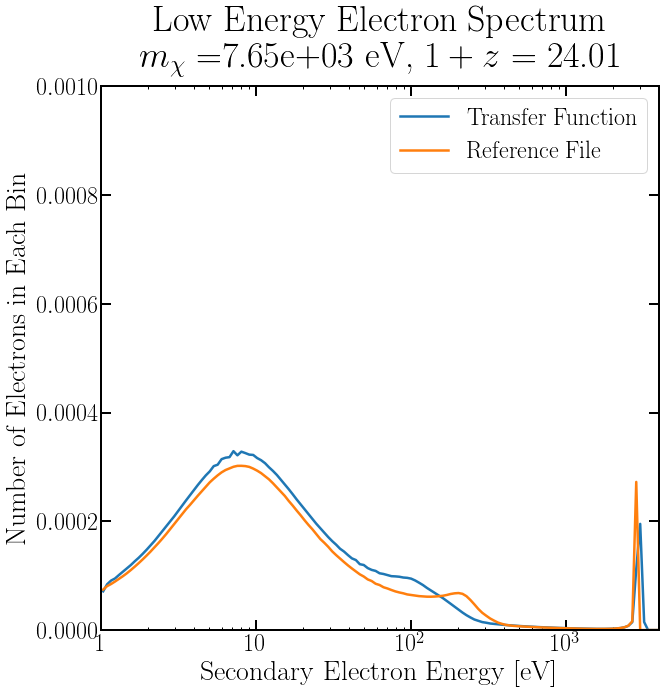

In [39]:
plt.figure()

rs_plot = 24.01

ax = plt.gca()
tf_plot, = lowengelec_spectra.plot(ax, ind=rs_plot, fac=1, indtype='rs')
file_plot, = combined_file_lowengelec_spectra.plot(ax, ind=rs_plot, indtype='rs')
# tf_plot, = lowengelec_spectra.plot(ax, ind=420)
# file_plot, = combined_file_lowengelec_spectra.plot(ax, ind=419)

ax.set_xscale('log')
# ax.set_yscale('log')
plt.title('Low Energy Electron Spectrum\n' + r'$m_\chi$ ='
          +'{:.2e}'.format(mwimp)
          +r' eV, $1+z$ = '+'{0:.2f}'.format(rs_plot)
         )

ax.legend((tf_plot, file_plot), ('Transfer Function', 'Reference File'))

plt.xlabel('Secondary Electron Energy [eV]')
plt.ylabel('Number of Electrons in Each Bin')
plt.axis([1, 4e3, 1e-15, .001])

In [24]:
i = 1
print(lowengelec_spectra[i].totN())
print(lowengelec_spectra[i].toteng())
print(combined_file_lowengelec_spectra[i].totN())
print(combined_file_lowengelec_spectra[i].toteng())

0.017379710099798294
1.2318750756413042
0.014802027842314007
1.1222466693081032


For keV photons, the discrepancies between the low energy photon and low energy electron spectra are large. This is because of the discontinuous behavior of photons above and below the 3 keV threshold: photons above the 3 keV threshold in the high energy code are made to photoionize, producing a secondary electron spectrum that has energy $E_\gamma - $ 13.6 eV, and then this is put through the electrons module to produce ICS and a resolved electron spectrum. Photons that are below 3 keV are simply saved. However, once they are processed in the low energy code, and CMB losses from ICS are taken into account, the effects should be similar.

[4, 35, 1e-14, 5e-11]

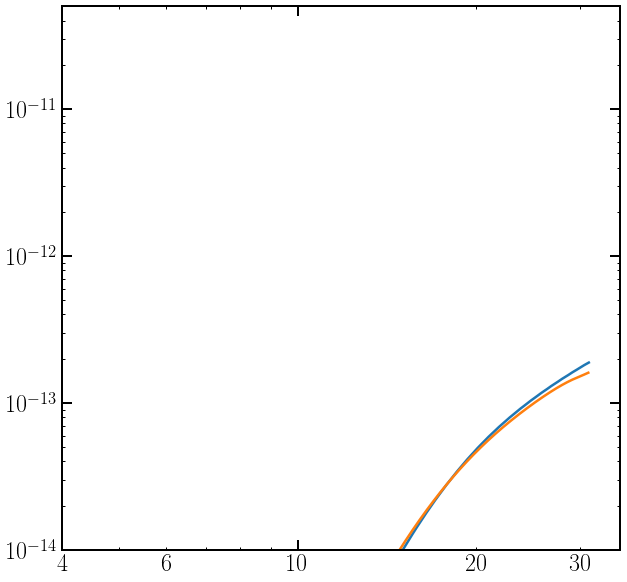

In [25]:
plt.figure()

ax = plt.gca()

tf_plot = plt.plot(rs_list, cmbloss)
file_plot = plt.plot(rs_list[1:-1], combined_file_cmbloss[1:])

ax.set_xscale('log')
ax.set_yscale('log')
plt.axis([4,35, 1e-14, 5e-11])

In [26]:
utils.compare_arr([lowengelec_spectra.eng, file_lowengelec_spectra.eng])

[[1.02978258e+00 1.02978258e+00]
 [1.09203515e+00 1.09203515e+00]
 [1.15805103e+00 1.15805103e+00]
 [1.22805771e+00 1.22805771e+00]
 [1.30229645e+00 1.30229645e+00]
 [1.38102307e+00 1.38102307e+00]
 [1.46450889e+00 1.46450889e+00]
 [1.55304161e+00 1.55304161e+00]
 [1.64692632e+00 1.64692632e+00]
 [1.74648657e+00 1.74648657e+00]
 [1.85206545e+00 1.85206545e+00]
 [1.96402679e+00 1.96402679e+00]
 [2.08275644e+00 2.08275644e+00]
 [2.20866356e+00 2.20866356e+00]
 [2.34218203e+00 2.34218203e+00]
 [2.48377198e+00 2.48377198e+00]
 [2.63392135e+00 2.63392135e+00]
 [2.79314757e+00 2.79314757e+00]
 [2.96199936e+00 2.96199936e+00]
 [3.14105861e+00 3.14105861e+00]
 [3.33094237e+00 3.33094237e+00]
 [3.53230501e+00 3.53230501e+00]
 [3.74584046e+00 3.74584046e+00]
 [3.97228459e+00 3.97228459e+00]
 [4.21241775e+00 4.21241775e+00]
 [4.46706748e+00 4.46706748e+00]
 [4.73711134e+00 4.73711134e+00]
 [5.02347992e+00 5.02347992e+00]
 [5.32716011e+00 5.32716011e+00]
 [5.64919842e+00 5.64919842e+00]
 [5.990704

0

# Greg's Checks

Do the reference spectra and Hongwan's spectra contain the same amount of energy?

In [27]:
print("Total % energy difference: ",
    1-(sum(combined_file_lowengphot_spectra.toteng()) 
     + sum(combined_file_lowengelec_spectra.toteng()))/(
    sum(lowengphot_spectra.toteng()) + sum(lowengelec_spectra.toteng())
    )
)

print("Electron % difference: ",
    1-sum(combined_file_lowengelec_spectra.toteng())/(
    sum(lowengelec_spectra.toteng())
    )
)

print("Photon % difference: ",
    1-sum(combined_file_lowengphot_spectra.toteng())/(
    sum(lowengphot_spectra.toteng())
    )
)

Total % energy difference:  0.07915337306624226
Electron % difference:  0.1084298735495921
Photon % difference:  0.06806976938819609


Determining x$_e$(z)

In [28]:
file_xes = file[1].data['hionfraction'][0,:]
std_xe_interp = scipy.interpolate.interp1d(file_rs, file_xes)

Computing f$_c$(z) (More description needed)

In [29]:
%autoreload
m_chi = 10**eng_exp
d_lnz = 2e-3
xe = 2.746e-4


rs_list = combined_file_lowengphot_spectra.rs
xes = std_xe_interp(rs_list)

eng = combined_file_lowengphot_spectra.eng
eng_bounds = spectools.get_bin_bound(eng)

#Ensure that electron and photon spectra have same rs abscissa
if np.any(np.abs(combined_file_lowengphot_spectra.rs - combined_file_lowengelec_spectra.rs) > 1e-6):
    sys.exit()
    
# indx at which photons can photoionize
ion_indx = spectools.get_indx(eng,phys.rydberg)

# max index at which math_rs_bounds fits in rs_list
max_indx = len(rs_list)
f_list = np.zeros([max_indx,5])
f_ref = np.zeros([max_indx,5])

for k in np.arange(max_indx):
    #Spectrum at kth rs
    
    loweng_phot = lowengphot_spectra[k]
    loweng_elec = lowengelec_spectra[k]
    loweng_phot.rs=1
    loweng_elec.rs=1
    
    phot_ref = combined_file_lowengphot_spectra[k]
    elec_ref = combined_file_lowengelec_spectra[k]
    phot_ref.rs=1
    elec_ref.rs=1

    
    
    #Include an energy of 10^-12 with occupation zero
    loweng_elec = Spectrum(
        np.insert(loweng_elec.eng, 0, 1e-12), np.insert(loweng_elec.N, 0, 0),
        rs=1, spec_type='N'
    )
    
    elec_ref = Spectrum(
        np.insert(elec_ref.eng, 0, 1e-12), np.insert(elec_ref.N, 0, 0),
        rs=1, spec_type='N'
    ) 
    
    
    
    # ionized electrons
    tmp_elec = Spectrum(
        loweng_phot.eng[ion_indx:], loweng_phot.N[ion_indx:], rs=1, spec_type='N'
    )
    new_eng = tmp_elec.eng - phys.rydberg
    
    tmp_elec_ref = Spectrum(
        phot_ref.eng[ion_indx:], phot_ref.N[ion_indx:], rs=1, spec_type='N'
    )
    new_eng_ref = elec_ref.eng - phys.rydberg
    
    if new_eng[0] < 0:
        #Don't allow negative energies
        new_eng = np.insert(new_eng[1:], 0, 1e-12)
    tmp_elec.shift_eng(new_eng)
    
    if new_eng_ref[0] < 0:
        #Don't allow negative energies
        new_eng_ref = np.insert(new_eng_ref[1:], 0, 1e-12)
    tmp_elec_ref.shift_eng(new_eng_ref)
    
    
    
    # rebin so that I may add ionized electrons to electron spectra
    indx = tmp_elec.eng.size
    tmp_elec.rebin(loweng_elec.eng[:indx+1])
    loweng_elec.N[:indx+1] += tmp_elec.N
    
    indx = tmp_elec_ref.eng.size
    tmp_elec_ref.rebin(elec_ref.eng[:indx+1])
    elec_ref.N[:indx+1] += tmp_elec_ref.N
    
    
    
    # Compute Transfer Functions
    T_phot = lowE_photons.compute_dep_inj_ratio(
        loweng_phot, np.array([1-xes[k], 0, 0]), 1, 1, 'old'
    )/phys.nB/(2*m_chi+0*phys.me)

    T_elec = lowE_electrons.compute_dep_inj_ratio(
        loweng_elec, xes[k], 1, 1
    )/phys.nB/(2*m_chi+0*phys.me)
    
    
    T_phot_ref = lowE_photons.compute_dep_inj_ratio(
        phot_ref, np.array([1-xes[k], 0, 0]), 1, 1, 'old'
    )/phys.nB/(2*m_chi+0*phys.me)

    T_elec_ref = lowE_electrons.compute_dep_inj_ratio(
        elec_ref, xes[k], 1, 1
    )/phys.nB/(2*m_chi+0*phys.me)
    
    f_list[k] = T_phot + T_elec
    f_ref[k] = T_phot_ref + T_elec_ref
    
    #subtract off the CMB part contributing to continuum photons
    #f_ref[k,0] -= sum(combined_file_cmbloss[k] * d_lnz /(
    #    phys.hubble(rs_list[k]) * 2 * m_chi
    #))
    
    #f_list[k,0] -= sum(CMB_engloss[k] * d_lnz /(
    #    phys.hubble(rs_list[k]) * 2 * m_chi
    #))
    #f_lists[k,0,coarse_indx] -= sum(file_engloss[indx1: indx2 + 1] * d_lnz /(
    #    phys.hubble(rs_list[indx1: indx2 + 1]) * 2 * m_chi
    #))
    
print('cont, exc, HI ion, He ion, heat: ', sum(f_list), '\n', sum(f_ref))

../darkhistory/spec/spectrum.py:748: RuntimeWarning: The new abscissa lies below the old one: only bins that lie within the new abscissa will be rebinned, bins above the abscissa will be discarded.
  warnings.warn("The new abscissa lies below the old one: only bins that lie within the new abscissa will be rebinned, bins above the abscissa will be discarded.", RuntimeWarning)


cont, exc, HI ion, He ion, heat:  [0.03640087 0.0522998  0.06070022 0.00360136 0.03115982] 
 [0.03400805 0.04834472 0.05609921 0.00331888 0.02884898]


In [30]:
print('% difference in f(z)\'s: ', np.abs(1-sum(sum(f_ref))/sum(sum(f_list))))

% difference in f(z)'s:  0.0735343350970602


In [31]:
#print('% difference in f(z)\'s: ', [1-np.max(np.abs(ref/llist)) for ref, llist in zip(f_ref, f_list)])

/Users/hongwan/anaconda/envs/python3/lib/python3.6/site-packages/matplotlib/axes/_base.py:3129: UserWarning: Attempted to set non-positive xlimits for log-scale axis; invalid limits will be ignored.
  'Attempted to set non-positive xlimits for log-scale axis; '
/Users/hongwan/anaconda/envs/python3/lib/python3.6/site-packages/matplotlib/axes/_base.py:3449: UserWarning: Attempted to set non-positive ylimits for log-scale axis; invalid limits will be ignored.
  'Attempted to set non-positive ylimits for log-scale axis; '


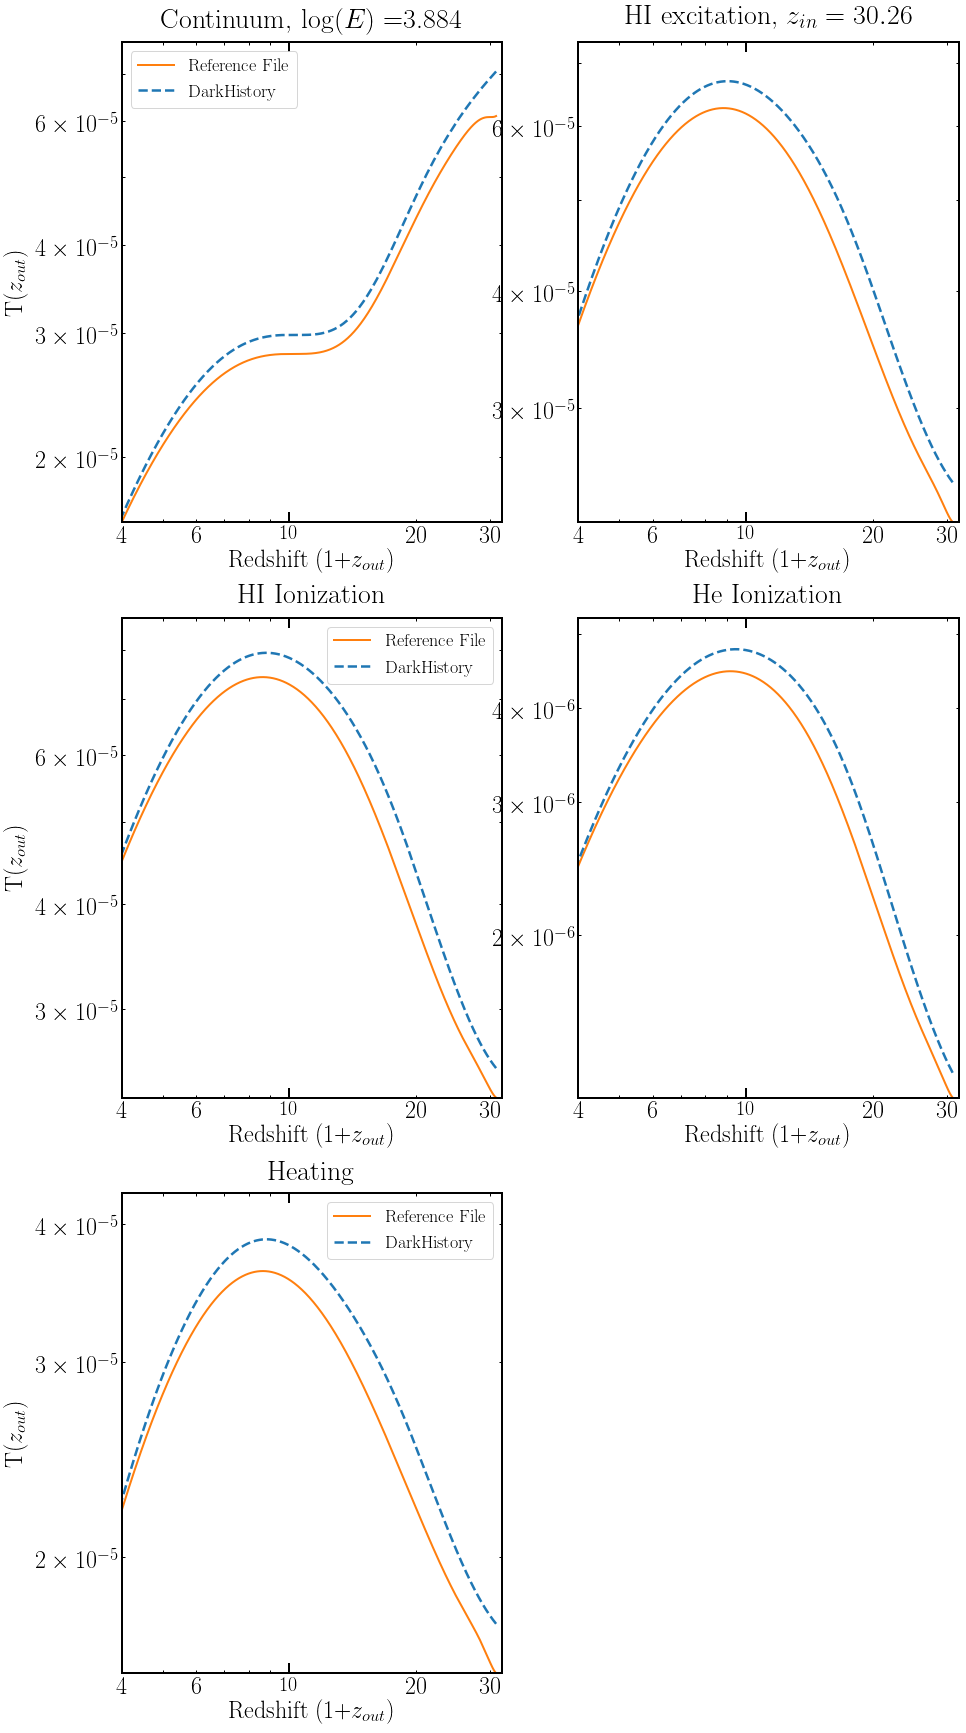

In [32]:
plt.figure(figsize=(15,30))

names = ["Continuum", "HI excitation", "HI Ionization", "He Ionization", "Heating"]

for num in np.arange(5):

    ax = plt.subplot(3,2,num+1)
    
    ax.set_xscale('log')
    ax.set_yscale('log')

    ref_tf_plt, = plt.plot(rs_list[:], f_ref[:,num], 'C1', linewidth=2, label='Reference File')
    new_tf_plt0, = plt.plot(rs_list[:], f_list[:,num], 'C0--', label='DarkHistory')

    plt.tick_params(axis='both', which='major', labelsize=20)

    if num == 0:
        plt.title(names[num]+', $\\log(E) = $'+str(eng_exp), fontsize=28)
    elif num == 1:
        plt.title(names[num]+', $z_{in} = 30.26$', fontsize=28)
    else:
        plt.title(names[num], fontsize=28)
    plt.xlabel('Redshift (1+$z_{out}$)',fontsize=24)
    if num%2 == 0:
        plt.ylabel('T($z_{out}$)',fontsize=24)
        plt.legend(handles=[ref_tf_plt, new_tf_plt0], 
            fontsize=18)
    plt.axis(
        [0, 32, 0, 1.1 * max(
            [max(f_list[:,num]),max(f_ref[:,num])]
        )]
    )

extra = 'DHv2'
plt.savefig('/Users/'+user+'/Dropbox (MIT)/Photon Deposition/plots/'+extra+
            '_log10(E)_'+str(eng_exp)+'.pdf')